In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv


In [2]:
!pip install jovian --upgrade --quiet

In [3]:
# Imports
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

<IPython.core.display.Javascript object>

In [4]:
df=pd.read_csv("/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv")

In [5]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
# Hyperparameters
batch_size=64
learning_rate=5e-7
input_size=11
output_size=1

In [7]:
# Convert from Pandas dataframe to numpy arrays
inputs = df.drop('quality', axis=1).values
targets = df[['quality']].values
inputs.shape, targets.shape

((1599, 11), (1599, 1))

In [8]:
# Convert to PyTorch dataset
dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32))
train_ds, val_ds = random_split(dataset, [1100,499])

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)

**MODEL**

In [9]:
class WineQualityModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = F.mse_loss(out, targets)    # Calculate loss
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = F.mse_loss(out, targets)    # Calculate loss
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))
    
    
model =WineQualityModel()

**TRAINING**

In [10]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [11]:
result = evaluate(model, val_loader)
result

{'val_loss': 37.917091369628906}

In [12]:
learning_rate=0.0001
history = fit(1000, learning_rate, model, train_loader, val_loader)

Epoch [0], val_loss: 3.7015
Epoch [1], val_loss: 2.5477
Epoch [2], val_loss: 1.6851
Epoch [3], val_loss: 1.2466
Epoch [4], val_loss: 1.1200
Epoch [5], val_loss: 0.8509
Epoch [6], val_loss: 0.8660
Epoch [7], val_loss: 0.7279
Epoch [8], val_loss: 0.6646
Epoch [9], val_loss: 0.6160
Epoch [10], val_loss: 0.5790
Epoch [11], val_loss: 0.5618
Epoch [12], val_loss: 0.5512
Epoch [13], val_loss: 0.5505
Epoch [14], val_loss: 0.5358
Epoch [15], val_loss: 0.6013
Epoch [16], val_loss: 0.5335
Epoch [17], val_loss: 0.6126
Epoch [18], val_loss: 0.5283
Epoch [19], val_loss: 0.5295
Epoch [20], val_loss: 0.5209
Epoch [21], val_loss: 0.5558
Epoch [22], val_loss: 0.5164
Epoch [23], val_loss: 0.5166
Epoch [24], val_loss: 0.5231
Epoch [25], val_loss: 0.5140
Epoch [26], val_loss: 0.5213
Epoch [27], val_loss: 0.5223
Epoch [28], val_loss: 0.5251
Epoch [29], val_loss: 0.5414
Epoch [30], val_loss: 0.5231
Epoch [31], val_loss: 0.5093
Epoch [32], val_loss: 0.5380
Epoch [33], val_loss: 0.7747
Epoch [34], val_loss: 0.

Epoch [285], val_loss: 0.4930
Epoch [286], val_loss: 0.4656
Epoch [287], val_loss: 0.4614
Epoch [288], val_loss: 0.4752
Epoch [289], val_loss: 0.4751
Epoch [290], val_loss: 0.4692
Epoch [291], val_loss: 0.4604
Epoch [292], val_loss: 0.4640
Epoch [293], val_loss: 0.4638
Epoch [294], val_loss: 0.7282
Epoch [295], val_loss: 0.4602
Epoch [296], val_loss: 0.4641
Epoch [297], val_loss: 0.4615
Epoch [298], val_loss: 0.4616
Epoch [299], val_loss: 0.4720
Epoch [300], val_loss: 0.4714
Epoch [301], val_loss: 0.4850
Epoch [302], val_loss: 0.4648
Epoch [303], val_loss: 0.4913
Epoch [304], val_loss: 0.4741
Epoch [305], val_loss: 0.4595
Epoch [306], val_loss: 0.4652
Epoch [307], val_loss: 0.4596
Epoch [308], val_loss: 0.4899
Epoch [309], val_loss: 0.4729
Epoch [310], val_loss: 0.4991
Epoch [311], val_loss: 0.4595
Epoch [312], val_loss: 0.4736
Epoch [313], val_loss: 0.4597
Epoch [314], val_loss: 0.4641
Epoch [315], val_loss: 0.4717
Epoch [316], val_loss: 0.4603
Epoch [317], val_loss: 0.4793
Epoch [318

Epoch [559], val_loss: 0.4605
Epoch [560], val_loss: 0.4562
Epoch [561], val_loss: 0.4575
Epoch [562], val_loss: 0.4621
Epoch [563], val_loss: 0.4576
Epoch [564], val_loss: 0.4918
Epoch [565], val_loss: 0.4616
Epoch [566], val_loss: 0.4562
Epoch [567], val_loss: 0.4833
Epoch [568], val_loss: 0.4715
Epoch [569], val_loss: 0.4564
Epoch [570], val_loss: 0.4601
Epoch [571], val_loss: 0.5151
Epoch [572], val_loss: 0.4562
Epoch [573], val_loss: 0.4755
Epoch [574], val_loss: 0.4560
Epoch [575], val_loss: 0.4752
Epoch [576], val_loss: 0.4666
Epoch [577], val_loss: 0.4944
Epoch [578], val_loss: 0.5552
Epoch [579], val_loss: 0.4661
Epoch [580], val_loss: 0.4668
Epoch [581], val_loss: 0.4601
Epoch [582], val_loss: 0.4559
Epoch [583], val_loss: 0.5569
Epoch [584], val_loss: 0.4563
Epoch [585], val_loss: 0.4599
Epoch [586], val_loss: 0.4686
Epoch [587], val_loss: 0.4611
Epoch [588], val_loss: 0.4815
Epoch [589], val_loss: 0.4558
Epoch [590], val_loss: 0.4656
Epoch [591], val_loss: 0.4566
Epoch [592

Epoch [840], val_loss: 0.4533
Epoch [841], val_loss: 0.4787
Epoch [842], val_loss: 0.4681
Epoch [843], val_loss: 0.6434
Epoch [844], val_loss: 0.4625
Epoch [845], val_loss: 0.4532
Epoch [846], val_loss: 0.4620
Epoch [847], val_loss: 0.4550
Epoch [848], val_loss: 0.4726
Epoch [849], val_loss: 0.4639
Epoch [850], val_loss: 0.4699
Epoch [851], val_loss: 0.5821
Epoch [852], val_loss: 0.4538
Epoch [853], val_loss: 0.4614
Epoch [854], val_loss: 0.4534
Epoch [855], val_loss: 0.4560
Epoch [856], val_loss: 0.4536
Epoch [857], val_loss: 0.4874
Epoch [858], val_loss: 0.4531
Epoch [859], val_loss: 0.4544
Epoch [860], val_loss: 0.4682
Epoch [861], val_loss: 0.4532
Epoch [862], val_loss: 0.4898
Epoch [863], val_loss: 0.4586
Epoch [864], val_loss: 0.4712
Epoch [865], val_loss: 0.4540
Epoch [866], val_loss: 0.4553
Epoch [867], val_loss: 0.4531
Epoch [868], val_loss: 0.5437
Epoch [869], val_loss: 0.4536
Epoch [870], val_loss: 0.4550
Epoch [871], val_loss: 0.4538
Epoch [872], val_loss: 0.4551
Epoch [873

In [13]:
learning_rate=0.00001
history = fit(1000, learning_rate, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4537
Epoch [1], val_loss: 0.4516
Epoch [2], val_loss: 0.4516
Epoch [3], val_loss: 0.4516
Epoch [4], val_loss: 0.4516
Epoch [5], val_loss: 0.4516
Epoch [6], val_loss: 0.4516
Epoch [7], val_loss: 0.4522
Epoch [8], val_loss: 0.4516
Epoch [9], val_loss: 0.4516
Epoch [10], val_loss: 0.4518
Epoch [11], val_loss: 0.4517
Epoch [12], val_loss: 0.4517
Epoch [13], val_loss: 0.4518
Epoch [14], val_loss: 0.4519
Epoch [15], val_loss: 0.4517
Epoch [16], val_loss: 0.4518
Epoch [17], val_loss: 0.4517
Epoch [18], val_loss: 0.4526
Epoch [19], val_loss: 0.4518
Epoch [20], val_loss: 0.4517
Epoch [21], val_loss: 0.4517
Epoch [22], val_loss: 0.4516
Epoch [23], val_loss: 0.4517
Epoch [24], val_loss: 0.4516
Epoch [25], val_loss: 0.4516
Epoch [26], val_loss: 0.4524
Epoch [27], val_loss: 0.4519
Epoch [28], val_loss: 0.4517
Epoch [29], val_loss: 0.4518
Epoch [30], val_loss: 0.4517
Epoch [31], val_loss: 0.4517
Epoch [32], val_loss: 0.4516
Epoch [33], val_loss: 0.4519
Epoch [34], val_loss: 0.

Epoch [285], val_loss: 0.4514
Epoch [286], val_loss: 0.4514
Epoch [287], val_loss: 0.4514
Epoch [288], val_loss: 0.4518
Epoch [289], val_loss: 0.4514
Epoch [290], val_loss: 0.4514
Epoch [291], val_loss: 0.4514
Epoch [292], val_loss: 0.4517
Epoch [293], val_loss: 0.4514
Epoch [294], val_loss: 0.4520
Epoch [295], val_loss: 0.4514
Epoch [296], val_loss: 0.4514
Epoch [297], val_loss: 0.4517
Epoch [298], val_loss: 0.4514
Epoch [299], val_loss: 0.4516
Epoch [300], val_loss: 0.4519
Epoch [301], val_loss: 0.4514
Epoch [302], val_loss: 0.4515
Epoch [303], val_loss: 0.4517
Epoch [304], val_loss: 0.4514
Epoch [305], val_loss: 0.4514
Epoch [306], val_loss: 0.4521
Epoch [307], val_loss: 0.4514
Epoch [308], val_loss: 0.4514
Epoch [309], val_loss: 0.4514
Epoch [310], val_loss: 0.4515
Epoch [311], val_loss: 0.4518
Epoch [312], val_loss: 0.4514
Epoch [313], val_loss: 0.4516
Epoch [314], val_loss: 0.4520
Epoch [315], val_loss: 0.4515
Epoch [316], val_loss: 0.4514
Epoch [317], val_loss: 0.4515
Epoch [318

Epoch [560], val_loss: 0.4512
Epoch [561], val_loss: 0.4513
Epoch [562], val_loss: 0.4513
Epoch [563], val_loss: 0.4512
Epoch [564], val_loss: 0.4517
Epoch [565], val_loss: 0.4513
Epoch [566], val_loss: 0.4518
Epoch [567], val_loss: 0.4517
Epoch [568], val_loss: 0.4512
Epoch [569], val_loss: 0.4512
Epoch [570], val_loss: 0.4512
Epoch [571], val_loss: 0.4547
Epoch [572], val_loss: 0.4516
Epoch [573], val_loss: 0.4512
Epoch [574], val_loss: 0.4512
Epoch [575], val_loss: 0.4512
Epoch [576], val_loss: 0.4512
Epoch [577], val_loss: 0.4512
Epoch [578], val_loss: 0.4511
Epoch [579], val_loss: 0.4511
Epoch [580], val_loss: 0.4516
Epoch [581], val_loss: 0.4513
Epoch [582], val_loss: 0.4512
Epoch [583], val_loss: 0.4512
Epoch [584], val_loss: 0.4512
Epoch [585], val_loss: 0.4512
Epoch [586], val_loss: 0.4513
Epoch [587], val_loss: 0.4517
Epoch [588], val_loss: 0.4512
Epoch [589], val_loss: 0.4517
Epoch [590], val_loss: 0.4512
Epoch [591], val_loss: 0.4512
Epoch [592], val_loss: 0.4516
Epoch [593

Epoch [840], val_loss: 0.4509
Epoch [841], val_loss: 0.4510
Epoch [842], val_loss: 0.4508
Epoch [843], val_loss: 0.4510
Epoch [844], val_loss: 0.4515
Epoch [845], val_loss: 0.4511
Epoch [846], val_loss: 0.4509
Epoch [847], val_loss: 0.4514
Epoch [848], val_loss: 0.4511
Epoch [849], val_loss: 0.4509
Epoch [850], val_loss: 0.4508
Epoch [851], val_loss: 0.4508
Epoch [852], val_loss: 0.4508
Epoch [853], val_loss: 0.4511
Epoch [854], val_loss: 0.4509
Epoch [855], val_loss: 0.4510
Epoch [856], val_loss: 0.4513
Epoch [857], val_loss: 0.4509
Epoch [858], val_loss: 0.4515
Epoch [859], val_loss: 0.4514
Epoch [860], val_loss: 0.4516
Epoch [861], val_loss: 0.4511
Epoch [862], val_loss: 0.4532
Epoch [863], val_loss: 0.4511
Epoch [864], val_loss: 0.4515
Epoch [865], val_loss: 0.4510
Epoch [866], val_loss: 0.4514
Epoch [867], val_loss: 0.4519
Epoch [868], val_loss: 0.4509
Epoch [869], val_loss: 0.4511
Epoch [870], val_loss: 0.4510
Epoch [871], val_loss: 0.4511
Epoch [872], val_loss: 0.4512
Epoch [873

In [14]:
learning_rate=0.000001
history = fit(500, learning_rate, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4508
Epoch [1], val_loss: 0.4509
Epoch [2], val_loss: 0.4509
Epoch [3], val_loss: 0.4509
Epoch [4], val_loss: 0.4509
Epoch [5], val_loss: 0.4509
Epoch [6], val_loss: 0.4509
Epoch [7], val_loss: 0.4510
Epoch [8], val_loss: 0.4509
Epoch [9], val_loss: 0.4509
Epoch [10], val_loss: 0.4510
Epoch [11], val_loss: 0.4510
Epoch [12], val_loss: 0.4509
Epoch [13], val_loss: 0.4509
Epoch [14], val_loss: 0.4509
Epoch [15], val_loss: 0.4509
Epoch [16], val_loss: 0.4509
Epoch [17], val_loss: 0.4508
Epoch [18], val_loss: 0.4509
Epoch [19], val_loss: 0.4509
Epoch [20], val_loss: 0.4508
Epoch [21], val_loss: 0.4509
Epoch [22], val_loss: 0.4508
Epoch [23], val_loss: 0.4508
Epoch [24], val_loss: 0.4508
Epoch [25], val_loss: 0.4508
Epoch [26], val_loss: 0.4508
Epoch [27], val_loss: 0.4508
Epoch [28], val_loss: 0.4508
Epoch [29], val_loss: 0.4508
Epoch [30], val_loss: 0.4508
Epoch [31], val_loss: 0.4508
Epoch [32], val_loss: 0.4508
Epoch [33], val_loss: 0.4508
Epoch [34], val_loss: 0.

Epoch [282], val_loss: 0.4509
Epoch [283], val_loss: 0.4509
Epoch [284], val_loss: 0.4509
Epoch [285], val_loss: 0.4509
Epoch [286], val_loss: 0.4508
Epoch [287], val_loss: 0.4508
Epoch [288], val_loss: 0.4508
Epoch [289], val_loss: 0.4508
Epoch [290], val_loss: 0.4508
Epoch [291], val_loss: 0.4508
Epoch [292], val_loss: 0.4508
Epoch [293], val_loss: 0.4508
Epoch [294], val_loss: 0.4508
Epoch [295], val_loss: 0.4508
Epoch [296], val_loss: 0.4508
Epoch [297], val_loss: 0.4508
Epoch [298], val_loss: 0.4508
Epoch [299], val_loss: 0.4508
Epoch [300], val_loss: 0.4508
Epoch [301], val_loss: 0.4508
Epoch [302], val_loss: 0.4508
Epoch [303], val_loss: 0.4508
Epoch [304], val_loss: 0.4508
Epoch [305], val_loss: 0.4508
Epoch [306], val_loss: 0.4508
Epoch [307], val_loss: 0.4508
Epoch [308], val_loss: 0.4508
Epoch [309], val_loss: 0.4508
Epoch [310], val_loss: 0.4508
Epoch [311], val_loss: 0.4507
Epoch [312], val_loss: 0.4507
Epoch [313], val_loss: 0.4507
Epoch [314], val_loss: 0.4507
Epoch [315

In [15]:
learning_rate=0.0000001
history = fit(500, learning_rate, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4507
Epoch [1], val_loss: 0.4507
Epoch [2], val_loss: 0.4507
Epoch [3], val_loss: 0.4507
Epoch [4], val_loss: 0.4507
Epoch [5], val_loss: 0.4507
Epoch [6], val_loss: 0.4507
Epoch [7], val_loss: 0.4507
Epoch [8], val_loss: 0.4507
Epoch [9], val_loss: 0.4507
Epoch [10], val_loss: 0.4507
Epoch [11], val_loss: 0.4507
Epoch [12], val_loss: 0.4507
Epoch [13], val_loss: 0.4507
Epoch [14], val_loss: 0.4507
Epoch [15], val_loss: 0.4507
Epoch [16], val_loss: 0.4507
Epoch [17], val_loss: 0.4507
Epoch [18], val_loss: 0.4507
Epoch [19], val_loss: 0.4507
Epoch [20], val_loss: 0.4507
Epoch [21], val_loss: 0.4507
Epoch [22], val_loss: 0.4507
Epoch [23], val_loss: 0.4507
Epoch [24], val_loss: 0.4507
Epoch [25], val_loss: 0.4507
Epoch [26], val_loss: 0.4507
Epoch [27], val_loss: 0.4507
Epoch [28], val_loss: 0.4507
Epoch [29], val_loss: 0.4507
Epoch [30], val_loss: 0.4507
Epoch [31], val_loss: 0.4507
Epoch [32], val_loss: 0.4507
Epoch [33], val_loss: 0.4507
Epoch [34], val_loss: 0.

Epoch [283], val_loss: 0.4508
Epoch [284], val_loss: 0.4508
Epoch [285], val_loss: 0.4508
Epoch [286], val_loss: 0.4508
Epoch [287], val_loss: 0.4508
Epoch [288], val_loss: 0.4508
Epoch [289], val_loss: 0.4508
Epoch [290], val_loss: 0.4508
Epoch [291], val_loss: 0.4508
Epoch [292], val_loss: 0.4508
Epoch [293], val_loss: 0.4508
Epoch [294], val_loss: 0.4508
Epoch [295], val_loss: 0.4508
Epoch [296], val_loss: 0.4508
Epoch [297], val_loss: 0.4508
Epoch [298], val_loss: 0.4508
Epoch [299], val_loss: 0.4508
Epoch [300], val_loss: 0.4508
Epoch [301], val_loss: 0.4508
Epoch [302], val_loss: 0.4508
Epoch [303], val_loss: 0.4508
Epoch [304], val_loss: 0.4508
Epoch [305], val_loss: 0.4508
Epoch [306], val_loss: 0.4508
Epoch [307], val_loss: 0.4508
Epoch [308], val_loss: 0.4508
Epoch [309], val_loss: 0.4508
Epoch [310], val_loss: 0.4508
Epoch [311], val_loss: 0.4508
Epoch [312], val_loss: 0.4508
Epoch [313], val_loss: 0.4508
Epoch [314], val_loss: 0.4508
Epoch [315], val_loss: 0.4508
Epoch [316

In [16]:
result = evaluate(model, val_loader)
result

{'val_loss': 0.45078063011169434}

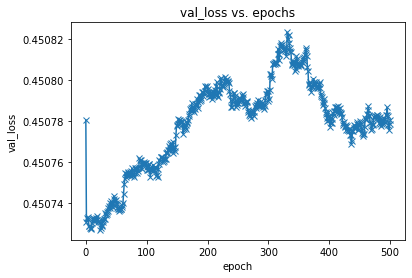

In [17]:
losses = [r['val_loss'] for r in [result] + history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('val_loss vs. epochs');

**PREDICTION**

In [18]:
def predict_single(x, model):
    xb = x.unsqueeze(0)
    return model(x).item()

In [19]:
x, target = val_ds[10]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([9.0000e+00, 8.2000e-01, 5.0000e-02, 2.4000e+00, 8.1000e-02, 2.6000e+01,
        9.6000e+01, 9.9814e-01, 3.3600e+00, 5.3000e-01, 1.0000e+01])
Target:  5.0
Prediction: 5.379953384399414


In [20]:
torch.save(model.state_dict(), 'housing-linear.pth')

In [21]:
jovian.commit(project='wine-quality', environment=None, outputs=['housing-linear.pth'])
jovian.commit(project='wine-quality', environment=None, outputs=['housing-linear.pth']) 

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/saurabhpalhade/wine-quality


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/saurabhpalhade/wine-quality


<IPython.core.display.Javascript object>